The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Probabilidade
:label:`sec_prob`

De uma forma ou de outra, o aprendizado de máquina envolve fazer previsões.
Podemos querer prever a *probabilidade* de um paciente sofrer um ataque cardíaco no próximo ano, considerando seu histórico clínico. Na detecção de anomalias, podemos avaliar quão *provável* seria um conjunto de leituras do motor a jato de um avião, se ele estivesse operando normalmente. Na aprendizagem por reforço, queremos que um agente aja de forma inteligente em um ambiente. Isso significa que precisamos pensar sobre a probabilidade de obter uma alta recompensa em cada uma das ações disponíveis. E quando construímos sistemas de recomendação, também precisamos pensar sobre probabilidade. Por exemplo, diga *hipoteticamente* que trabalhamos para uma grande livraria online. Podemos querer estimar a probabilidade de um determinado usuário comprar um determinado livro. Para isso, precisamos usar a linguagem da probabilidade.
Cursos inteiros, graduações, teses, carreiras e até departamentos são dedicados à probabilidade. Então, naturalmente, nosso objetivo nesta seção não é ensinar todo o assunto. Em vez disso, esperamos fazer você decolar, ensinar apenas o suficiente para que você possa começar a construir seus primeiros modelos de *Deep Learning* e dar-lhe um sabor suficiente para o assunto que você pode começar a explorá-lo por conta própria, se desejar.

Já invocamos as probabilidades nas seções anteriores, sem articular o que são precisamente ou dar um exemplo concreto. Vamos ser mais sérios agora, considerando o primeiro caso: distinguir cães e gatos com base em fotografias. Isso pode parecer simples, mas na verdade é um desafio formidável. Para começar, a dificuldade do problema pode depender da resolução da imagem.

![Imagens de diferentes resoluções ($10 \times 10$, $20 \times 20$, $40 \times 40$, $80 \times 80$, e $160 \times 160$ pixels).](../img/cat-dog-pixels.png)
:width:`300px`
:label:`fig_cat_dog`

Conforme mostrado em :numref:`fig_cat_dog`,
embora seja fácil para os humanos reconhecerem cães e gatos na resolução de $160 \times 160$ pixels,
torna-se um desafio em $40 \times 40$ pixels e quase impossível em $10 \times 10$ pixels.
Em outras palavras, nossa capacidade de distinguir cães e gatos a uma grande distância (e, portanto, em baixa resolução) pode se aproximar de uma suposição desinformada. A probabilidade nos dá um
maneira formal de raciocinar sobre nosso nível de certeza.
Se tivermos certeza absoluta
que a imagem representa um gato, dizemos que a *probabilidade* de que o rótulo $y$ correspondente seja "cat", denotado $P(y=$ "cat"$)$ é igual a $1$.
Se não tivéssemos nenhuma evidência para sugerir que $y =$ "cat" ou que $y =$ "dog", então poderíamos dizer que as duas possibilidades eram igualmente
*provavelmente* expressando isso como  $P(y=$ "cat"$) = P(y=$ "dog"$) = 0.5$. Se estivéssemos razoavelmente
confiantes, mas não temos certeza de que a imagem representava um gato, podemos atribuir um
probabilidade $0,5 <P (y = $"cat"$) <1$.

Agora considere o segundo caso: dados alguns dados de monitoramento do tempo, queremos prever a probabilidade de que choverá em Taipei amanhã. Se for verão, a chuva pode vir com probabilidade 0,5.

Em ambos os casos, temos algum valor de interesse. E em ambos os casos não temos certeza sobre o resultado.
Mas existe uma diferença fundamental entre os dois casos. Neste primeiro caso, a imagem é de fato um cachorro ou um gato, e simplesmente não sabemos qual. No segundo caso, o resultado pode realmente ser um evento aleatório, se você acredita em tais coisas (e a maioria dos físicos acredita). Portanto, probabilidade é uma linguagem flexível para raciocinar sobre nosso nível de certeza e pode ser aplicada com eficácia em um amplo conjunto de contextos.

## Teoria Básica de Probabilidade

Digamos que lançamos um dado e queremos saber qual é a chance de ver um 1 em vez de outro dígito. Se o dado for justo, todos os seis resultados $\{1, \ldots, 6\}$ têm a mesma probabilidade de ocorrer e, portanto, veríamos $1$ em um dos seis casos. Formalmente afirmamos que $1$ ocorre com probabilidade $\frac{1}{6}$.

Para um dado real que recebemos de uma fábrica, podemos não saber essas proporções e precisaríamos verificar se ele está contaminado. A única maneira de investigar o dado é lançando-o várias vezes e registrando os resultados. Para cada lançamento do dado, observaremos um valor em $\{1, \ldots, 6\}$. Dados esses resultados, queremos investigar a probabilidade de observar cada resultado.

Uma abordagem natural para cada valor é pegar o
contagem individual para aquele valor e dividi-lo pelo número total de jogadas.
Isso nos dá uma *estimativa* da probabilidade de um determinado *evento*. A *lei de
grandes números* nos dizem que, conforme o número de lançamentos aumenta, essa estimativa se aproxima cada vez mais da verdadeira probabilidade subjacente. Antes de entrar em detalhes sobre o que está acontecendo aqui, vamos experimentar.

Para começar, importemos os pacotes necessários.


In [1]:
%matplotlib inline
import random
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

Em seguida, queremos ser capazes de lançar o dado. Nas estatísticas, chamamos este processo
de colher exemplos de  *amostragem* de distribuições de probabilidade .
A distribuição
que atribui probabilidades a uma série de escolhas discretas é chamado de
*distribuição multinomial*. Daremos uma definição mais formal de
*distribuição* mais tarde, mas em um alto nível, pense nisso como apenas uma atribuição de
probabilidades para eventos.

Para obter uma única amostra, simplesmente passamos um vetor de probabilidades.
A saída é outro vetor do mesmo comprimento:
seu valor no índice $i$ é o número de vezes que o resultado da amostragem corresponde a $i$.


In [2]:
fair_probs = [1.0 / 6] * 6
np.random.multinomial(1, fair_probs)

array([0, 0, 0, 1, 0, 0], dtype=int64)

Se você executar o amostrador várias vezes, descobrirá que sai aleatoriamente
valores de cada vez. Tal como acontece com a estimativa da justiça de um dado, muitas vezes queremos
gerar muitas amostras da mesma distribuição. Seria insuportavelmente lento para
fazer isso com um loop Python `for`, então a função que estamos usando suporta gerar
várias amostras de uma vez, retornando uma matriz de amostras independentes em qualquer forma
podemos desejar.


In [3]:
np.random.multinomial(10, fair_probs)

array([1, 1, 5, 1, 1, 1], dtype=int64)

Agora que sabemos como obter amostras de um dado, podemos simular 1000 execuções.
Podemos então passar e contar, após cada um dos 1000 lançamentos, quantas vezes cada
número foi rolado.
Especificamente, calculamos a frequência relativa como a estimativa da probabilidade verdadeira.


In [4]:
counts = np.random.multinomial(1000, fair_probs).astype(np.float32)
counts / 1000

array([0.162, 0.149, 0.178, 0.17 , 0.166, 0.175])

Como geramos os dados de um dado justo, sabemos que cada resultado tem probabilidade real $\frac{1}{6}$, cerca de $0,167$, portanto, as estimativas de saída acima parecem boas.

Também podemos visualizar como essas probabilidades convergem ao longo do tempo para a probabilidade verdadeira.
Vamos conduzir 500 grupos de experimentos onde cada grupo extrai 10 amostras.


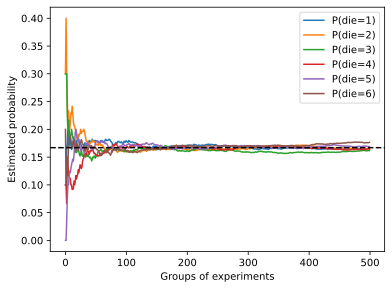

In [5]:
counts = np.random.multinomial(10, fair_probs, size=500)
cum_counts = counts.astype(np.float32).cumsum(axis=0)
estimates = cum_counts / cum_counts.sum(axis=1, keepdims=True)

d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].asnumpy(),
                 label=("P(die=" + str(i + 1) + ")"))
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

Cada curva sólida corresponde a um dos seis valores do dado e dá nossa probabilidade estimada de que o dado aumente esse valor conforme avaliado após cada grupo de experimentos.
A linha preta tracejada fornece a verdadeira probabilidade subjacente.
À medida que obtemos mais dados conduzindo mais experimentos,
as curvas sólidas de $6$ convergem para a probabilidade verdadeira.

### Axiomas da Teoria de Probabilidade

Ao lidar com as jogadas de um dado,
chamamos o conjunto $\mathcal{S} = \{1, 2, 3, 4, 5, 6\}$ o *espaço de amostra* ou *espaço de resultado*, onde cada elemento é um *resultado*.
Um *evento* é um conjunto de resultados de um determinado espaço amostral.
Por exemplo, "ver $5$" ($\{5 \}$) e "ver um número ímpar" ($\{1, 3, 5 \}$) são eventos válidos de lançar um dado.
Observe que se o resultado de um experimento aleatório estiver no evento $\mathcal {A}$,
então o evento $\mathcal {A}$ ocorreu.
Ou seja, se $3$ pontos virados para cima após rolar um dado, uma vez que $3 \in \{1, 3, 5 \}$,
podemos dizer que o evento "ver um número ímpar" ocorreu.

Formalmente, *probabilidade* pode ser pensada como uma função que mapeia um conjunto para um valor real.
A probabilidade de um evento $\mathcal {A}$ no espaço amostral dado $\mathcal {S}$,
denotado como $P (\mathcal {A})$, satisfaz as seguintes propriedades:

* Para qualquer evento $\mathcal {A}$, sua probabilidade nunca é negativa, ou seja, $P (\mathcal {A}) \geq 0$;
* A probabilidade de todo o espaço amostral é $1$, ou seja, $P (\mathcal {S}) = 1$;
* Para qualquer sequência contável de eventos $\mathcal {A} _1, \mathcal {A} _2, \ldots$ que são *mutuamente exclusivos* ($\mathcal{A}_i \cap \mathcal{A}_j = \emptyset$ para todo $i \neq j$), a probabilidade de que aconteça é igual à soma de suas probabilidades individuais, ou seja, $P(\bigcup_{i=1}^{\infty} \mathcal{A}_i) = \sum_{i=1}^{\infty} P(\mathcal{A}_i)$.

Esses também são os axiomas da teoria das probabilidades, propostos por Kolmogorov em 1933.
Graças a este sistema de axiomas, podemos evitar qualquer disputa filosófica sobre aleatoriedade;
em vez disso, podemos raciocinar rigorosamente com uma linguagem matemática.
Por exemplo, permitindo que o evento $\mathcal{A}_1$ seja todo o espaço da amostra e $\mathcal{A}_i = \emptyset$ para todos $i> 1$, podemos provar que $P(\emptyset) = 0$, ou seja, a probabilidade de um evento impossível é $0$.

### Variáveis Aleatórias

Em nosso experimento aleatório de lançar um dado, introduzimos a noção de uma *variável aleatória*. Uma variável aleatória pode ser praticamente qualquer quantidade e não é determinística. Pode assumir um valor entre um conjunto de possibilidades em um experimento aleatório.
Considere uma variável aleatória $X$ cujo valor está no espaço amostral $\mathcal {S} = \{1, 2, 3, 4, 5, 6 \}$ do lançamento de um dado. Podemos denotar o evento "vendo $5$" como $\{X = 5 \}$ ou $X = 5$, e sua probabilidade como $P (\{X = 5 \})$ ou $P (X = 5)$.
Por $P (X = a)$, fazemos uma distinção entre a variável aleatória $X$ e os valores (por exemplo, $a$) que $X$ pode assumir.
No entanto, esse pedantismo resulta em uma notação complicada.
Para uma notação compacta,
por um lado, podemos apenas denotar $P (X)$ como a *distribuição* sobre a variável aleatória $X$:
a distribuição nos diz a probabilidade de que $X$ assuma qualquer valor.
Por outro lado,
podemos simplesmente escrever $P (a)$ para denotar a probabilidade de uma variável aleatória assumir o valor $a$.
Uma vez que um evento na teoria da probabilidade é um conjunto de resultados do espaço amostral,
podemos especificar um intervalo de valores para uma variável aleatória assumir.
Por exemplo, $P(1 \leq X \leq 3)$ denota a probabilidade do evento $\{1 \leq X \leq 3\}$,
o que significa $\{X = 1, 2, \text{or}, 3\}$. De forma equivalente, $\{X = 1, 2, \text{or}, 3\}$ representa a probabilidade de que a variável aleatória $X$ possa assumir um valor de $\{1, 2, 3\}$.

Observe que há uma diferença sutil entre variáveis ​​aleatórias *discretas*, como os lados de um dado, e *contínuas*, como o peso e a altura de uma pessoa. Não adianta perguntar se duas pessoas têm exatamente a mesma altura. Se tomarmos medidas precisas o suficiente, você descobrirá que duas pessoas no planeta não têm exatamente a mesma altura. Na verdade, se fizermos uma medição suficientemente precisa, você não terá a mesma altura ao acordar e ao dormir. Portanto, não há nenhum propósito em perguntar sobre a probabilidade
que alguém tem 1,80139278291028719210196740527486202 metros de altura. Dada a população mundial de humanos, a probabilidade é virtualmente 0. Faz mais sentido, neste caso, perguntar se a altura de alguém cai em um determinado intervalo, digamos entre 1,79 e 1,81 metros. Nesses casos, quantificamos a probabilidade de vermos um valor como uma *densidade*. A altura de exatamente 1,80 metros não tem probabilidade, mas densidade diferente de zero. No intervalo entre quaisquer duas alturas diferentes, temos probabilidade diferente de zero.
No restante desta seção, consideramos a probabilidade no espaço discreto.
Para probabilidade sobre variáveis ​​aleatórias contínuas, você pode consultar :numref:`sec_random_variables`.

## Lidando com Múltiplas Variáveis Aleatórias

Muitas vezes, queremos considerar mais de uma variável aleatória de cada vez.
Por exemplo, podemos querer modelar a relação entre doenças e sintomas. Dados uma doença e um sintoma, digamos "gripe" e "tosse", podem ou não ocorrer em um paciente com alguma probabilidade. Embora esperemos que a probabilidade de ambos seja próxima de zero, podemos estimar essas probabilidades e suas relações entre si para que possamos aplicar nossas inferências para obter um melhor atendimento médico.

Como um exemplo mais complicado, as imagens contêm milhões de pixels, portanto, milhões de variáveis aleatórias. E, em muitos casos, as imagens vêm com um
rótulo, identificando objetos na imagem. Também podemos pensar no rótulo como um
variável aleatória. Podemos até pensar em todos os metadados como variáveis aleatórias
como local, tempo, abertura, comprimento focal, ISO, distância de foco e tipo de câmera.
Todas essas são variáveis aleatórias que ocorrem em conjunto. Quando lidamos com múltiplas variáveis aleatórias, existem várias quantidades de interesse.

### Probabilidade Conjunta

O primeiro é chamado de *probabilidade conjunta* $P(A = a, B=b)$. Dados quaisquer valores $a$ e $b$, a probabilidade conjunta nos permite responder, qual é a probabilidade de que $A = a$ e $B = b$ simultaneamente?
Observe que, para quaisquer valores $a$ e $b$, $P (A = a, B = b) \leq P (A = a)$.
Tem de ser este o caso, visto que para $A = a$ e $B = b$ acontecer, $A = a$ tem que acontecer *e* $B = b$ também tem que acontecer (e vice-versa). Assim, $A = a$ e $B = b$ não podem ser mais prováveis do que $A = a$ ou $B = b$ individualmente.

### Probabilidade Condicional

Isso nos leva a uma razão interessante: $0 \leq \frac {P (A = a, B = b)} {P (A = a)} \leq 1$. Chamamos essa proporção de *probabilidade condicional*
e denotá-lo por $P (B = b \mid A = a)$: é a probabilidade de $B = b$, desde que
$A = a$ ocorreu.

### Teorema de Bayes

Usando a definição de probabilidades condicionais, podemos derivar uma das equações mais úteis e celebradas em estatística: *Teorema de Bayes*.
Por construção, temos a *regra de multiplicação* que $P(A, B) = P(B \mid A) P(A)$. Por simetria, isso também é válido para $P(A, B) = P(A \mid B) P(B)$. Suponha que $P(B)> 0$. Resolvendo para uma das variáveis condicionais, obtemos

$$P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}.$$

Observe que aqui usamos a notação mais compacta em que $P(A, B)$ é uma *distribuição conjunta* e $P(A \mid B)$ é uma *distribuição condicional*. Essas distribuições podem ser avaliadas para valores particulares $A = a, B = b$.

### Marginalização

O teorema de Bayes é muito útil se quisermos inferir uma coisa da outra, digamos causa e efeito, mas só conhecemos as propriedades na direção reversa, como veremos mais adiante nesta seção. Uma operação importante de que precisamos para fazer esse trabalho é a *marginalização*.
É a operação de determinar $P(B)$ de $P(A, B)$. Podemos ver que a probabilidade de $B$ equivale a contabilizar todas as escolhas possíveis de $A$ e agregar as probabilidades conjuntas de todas elas:

$$P(B) = \sum_{A} P(A, B),$$

que também é conhecida como *regra da soma*. A probabilidade ou distribuição como resultado da marginalização é chamada de *probabilidade marginal* ou *distribuição marginal*.

### Independencia

Outra propriedade útil para verificar é *dependência* vs. *independência*.
Duas variáveis aleatórias $A$ e $B$ sendo independentes
significa que a ocorrência de um evento de $A$
não revela nenhuma informação sobre a ocorrência de um evento de $B$.
Neste caso $P(B \mid A) = P(B)$. Os estatísticos normalmente expressam isso como $A \perp  B$. Do teorema de Bayes, segue imediatamente que também $P(A \mid B) = P(A)$.
Em todos os outros casos, chamamos $A$ e $B$ de dependente. Por exemplo, duas jogadas sucessivas de um dado são independentes. Em contraste, a posição de um interruptor de luz e a luminosidade da sala não são (eles não são perfeitamente determinísticos, pois podemos sempre ter uma lâmpada quebrada, falha de energia ou um interruptor quebrado).

Dado que $P(A \mid B) = \frac{P(A, B)}{P(B)} = P(A)$ é equivalente a $P(A, B) = P(A)P(B)$, duas variáveis aleatórias são independentes se e somente se sua distribuição conjunta é o produto de suas distribuições individuais.
Da mesma forma, duas variáveis aleatórias $A$ e $B$ são *condicionalmente independentes* dada outra variável aleatória $C$
se e somente se $P(A, B \mid C) = P(A \mid C)P(B \mid C)$. Isso é expresso como $A \perp B \mid C$.

### Aplicação
:label:`subsec_probability_hiv_app`

Vamos colocar nossas habilidades à prova. Suponha que um médico administre um teste de HIV a um paciente. Este teste é bastante preciso e falha apenas com 1% de probabilidade se o paciente for saudável, mas relatá-lo como doente. Além disso,
nunca deixa de detectar o HIV se o paciente realmente o tiver. Usamos $D_1$ para indicar o diagnóstico ($1$ se positivo e $0$ se negativo) e $H$ para denotar o estado de HIV ($1$ se positivo e $0$ se negativo).
:numref:`conditional_prob_D1` lista tais probabilidades condicionais.
:
Probabilidade condicional de $P(D_1 \mid H)$.

| Probabilidade Condicional | $H=1$ | $H=0$ |
|---|---|---|
|$P(D_1 = 1 \mid H)$|            1 |         0.01 |
|$P(D_1 = 0 \mid H)$|            0 |         0.99 |
:label:`conditional_prob_D1`

Observe que as somas das colunas são todas 1 (mas as somas das linhas não), uma vez que a probabilidade condicional precisa somar 1, assim como a probabilidade. Vamos calcular a probabilidade de o paciente ter HIV se o teste der positivo, ou seja, $P(H = 1 \mid D_1 = 1)$. Obviamente, isso vai depender de quão comum é a doença, já que afeta o número de alarmes falsos. Suponha que a população seja bastante saudável, por exemplo, $P(H=1) = 0.0015$. Para aplicar o teorema de Bayes, precisamos aplicar a marginalização e a regra de multiplicação para determinar

$$\begin{aligned}
&P(D_1 = 1) \\
=& P(D_1=1, H=0) + P(D_1=1, H=1)  \\
=& P(D_1=1 \mid H=0) P(H=0) + P(D_1=1 \mid H=1) P(H=1) \\
=& 0.011485.
\end{aligned}
$$

Portanto, obtemos:

$$\begin{aligned}
&P(H = 1 \mid D_1 = 1)\\ =& \frac{P(D_1=1 \mid H=1) P(H=1)}{P(D_1=1)} \\ =& 0.1306 \end{aligned}.$$

Em outras palavras, há apenas 13,06% de chance de que o paciente
realmente tem HIV, apesar de usar um teste muito preciso.
Como podemos ver, a probabilidade pode ser contra-intuitiva.

O que o paciente deve fazer ao receber notícias tão terríveis? Provavelmente, o paciente
pediria ao médico para administrar outro teste para obter clareza. O segundo
teste tem características diferentes e não é tão bom quanto o primeiro, como mostrado em :numref:conditional_prob_D2`.

:Probabilidade Condicional de $P(D_2 \mid H)$.

| Probabilidade Condicional | $H=1$ | $H=0$ |
|---|---|---|
|$P(D_2 = 1 \mid H)$|            0.98 |         0.03 |
|$P(D_2 = 0 \mid H)$|            0.02 |         0.97 |
:label:`conditional_prob_D2`

Infelizmente, o segundo teste também deu positivo.
Vamos trabalhar as probabilidades necessárias para invocar o teorema de Bayes
assumindo a independência condicional:

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1 \mid H = 0) \\
=& P(D_1 = 1 \mid H = 0) P(D_2 = 1 \mid H = 0)  \\
=& 0.0003,
\end{aligned}
$$

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1 \mid H = 1) \\
=& P(D_1 = 1 \mid H = 1) P(D_2 = 1 \mid H = 1)  \\
=& 0.98.
\end{aligned}
$$

Agora podemos aplicar a marginalização e a regra de multiplicação:

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1) \\
=& P(D_1 = 1, D_2 = 1, H = 0) + P(D_1 = 1, D_2 = 1, H = 1)  \\
=& P(D_1 = 1, D_2 = 1 \mid H = 0)P(H=0) + P(D_1 = 1, D_2 = 1 \mid H = 1)P(H=1)\\
=& 0.00176955.
\end{aligned}
$$

No final, a probabilidade de o paciente ter HIV, dado ambos os testes positivos, é

$$\begin{aligned}
&P(H = 1 \mid D_1 = 1, D_2 = 1)\\
=& \frac{P(D_1 = 1, D_2 = 1 \mid H=1) P(H=1)}{P(D_1 = 1, D_2 = 1)} \\
=& 0.8307.
\end{aligned}
$$

Ou seja, o segundo teste nos permitiu ganhar uma confiança muito maior de que nem tudo está bem. Apesar do segundo teste ser consideravelmente menos preciso do que o primeiro, ele ainda melhorou significativamente nossa estimativa.



## Expectativa e Variância

Para resumir as principais características das distribuições de probabilidade,
precisamos de algumas medidas.
A *expectativa* (ou média) da variável aleatória $X$ é denotada como

$$E[X] = \sum_{x} x P(X = x).$$

Quando a entrada de uma função $f (x)$ é uma variável aleatória retirada da distribuição $P$ com valores diferentes $x$,
a expectativa de $f (x)$ é calculada como

$$E_{x \sim P}[f(x)] = \sum_x f(x) P(x).$$

Em muitos casos, queremos medir o quanto a variável aleatória $X$ se desvia de sua expectativa. Isso pode ser quantificado pela variação

$$\mathrm{Var}[X] = E\left[(X - E[X])^2\right] =
E[X^2] - E[X]^2.$$

Sua raiz quadrada é chamada de *desvio padrão*.
A variância de uma função de uma variável aleatória mede
pelo quanto a função se desvia da expectativa da função,
como diferentes valores $x$ da variável aleatória são amostrados de sua distribuição:

$$\mathrm{Var}[f(x)] = E\left[\left(f(x) - E[f(x)]\right)^2\right].$$


## Sumário

* Podemos obter amostras de distribuições de probabilidade.
* Podemos analisar múltiplas variáveis aleatórias usando distribuição conjunta, distribuição condicional, teorema de Bayes, marginalização e suposições de independência.
* A expectativa e a variância oferecem medidas úteis para resumir as principais características das distribuições de probabilidade.

## Exercícios

1. Conduzimos $m = 500$ grupos de experimentos onde cada grupo extrai $n = 10$ amostras. Varie $m$ e $n$. Observe e analise os resultados experimentais.
1. Dados dois eventos com probabilidade $P(\mathcal{A})$ e $P(\mathcal{B})$, calcule os limites superior e inferior em $P(\mathcal{A} \cup \mathcal{B})$ e $P(\mathcal{A} \cap \mathcal{B})$. (Dica: exiba a situação usando um [Diagrama de Venn](https://en.wikipedia.org/wiki/Venn_diagram).)
1. Suponha que temos uma sequência de variáveis aleatórias, digamos $A$, $B$ e $C$, onde $B$ depende apenas de $A$ e $C$ depende apenas de $B$, você pode simplificar a probabilidade conjunta $P (A, B, C)$? (Dica: esta é uma [Cadeia de Markov](https://en.wikipedia.org/wiki/Markov_chain).)
1. Em :numref:`subsec_probability_hiv_app`, o primeiro teste é mais preciso. Por que não executar o primeiro teste duas vezes em vez de executar o primeiro e o segundo testes?


[Discussão](https://discuss.d2l.ai/t/36)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTEwMDE3OTA0NTMsMTk4ODQ4MjczNCwtMj
E0MzE0MTM1Miw4MTkwMzI1MzgsMTQ2MzA1NTE4OSwtMTIzNTI4
NzEyNywxODQwNDYyMTU3LDM0MDgxNDk1LC0xNjk1ODQ3NDYxLD
M3Mjg4NzE1OCw4MTk5MjQwMThdfQ==
-->
